### TCGA <-> CCLE mutation prediction: LASSO parameter range experiments, summary across all genes

Here, we're interested in:

* Training mutation status models on data from TCGA (human tumor samples) and testing on data from CCLE (cancer cell lines), or
* Training mutation status models on data from CCLE and testing on data from TCGA

This is similar to our other experiments where we hold out and evaluate on all data from a single cancer type, but now the "domains" are entire datasets rather than cancer types from the same dataset.

This script plots the summarized results of varying regularization strength (LASSO parameter) across all genes in our cancer driver gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# direction to plot results for
# 'ccle_tcga' (train CCLE, test TCGA) or 'tcga_ccle' (train TCGA, test CCLE)
direction = 'ccle_tcga'

if direction == 'ccle_tcga':
    results_dir = os.path.join(
        cfg.repo_root, '08_cell_line_prediction', 'results', 'ccle_to_tcga'
    )
else:
    results_dir = os.path.join(
        cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_to_ccle'
    )

# performance metric: 'aupr' or 'auroc'
metric = 'aupr'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'generalization_plots'
)

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.drop(columns=['cancer_type'], inplace=True)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)

print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(11868, 5)
['TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'NPM1' 'PBRM1'
 'MET' 'CDKN2A' 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'BCOR'
 'NRAS' 'ERBB2' 'ARID1A' 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11'
 'NOTCH1' 'STAG2' 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2'
 'VHL' 'IDH1' 'EP300' 'ATRX' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8'
 'SOX9' 'GNAQ' 'KRAS' 'JAK2' 'EZH2']


,gene,lasso_param,seed,fold,nz_coefs
0,TP53,3.160000e-01,1,0,347
1,TP53,3.160000e-01,1,1,360
2,TP53,3.160000e-01,1,2,409
3,TP53,3.160000e-01,1,3,366
4,TP53,3.160000e+07,1,0,15272


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, 'tcga_to_ccle')
perf_df.drop(columns=['holdout_cancer_type'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(35604, 9)
['TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'NPM1' 'PBRM1'
 'MET' 'CDKN2A' 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'BCOR'
 'NRAS' 'ERBB2' 'ARID1A' 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11'
 'NOTCH1' 'STAG2' 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2'
 'VHL' 'IDH1' 'EP300' 'ATRX' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8'
 'SOX9' 'GNAQ' 'KRAS' 'JAK2' 'EZH2']


,auroc,aupr,gene,signal,seed,data_type,fold,experiment,lasso_param
0,0.5,0.68434,TP53,signal,1,train,0,tcga_to_ccle,0.00316
1,0.5,0.47619,TP53,signal,1,test,0,tcga_to_ccle,0.00316
2,0.5,0.70025,TP53,signal,1,cv,0,tcga_to_ccle,0.00316
3,0.5,0.68939,TP53,signal,1,train,1,tcga_to_ccle,0.00316
4,0.5,0.47619,TP53,signal,1,test,1,tcga_to_ccle,0.00316


### Distribution of model sizes (number of nonzero coefficients)

In [5]:
coefs_perf_df = (nz_coefs_df
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal', 'experiment'])
)

print(coefs_perf_df.shape)
coefs_perf_df.head()

(35604, 8)


,gene,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
0,TP53,0.316,1,0,347,1.00000,1.00000,train
1,TP53,0.316,1,0,347,0.77738,0.73550,test
2,TP53,0.316,1,0,347,0.87936,0.92172,cv
3,TP53,0.316,1,1,360,1.00000,1.00000,train
4,TP53,0.316,1,1,360,0.78360,0.72671,test


Text(0.5, 0, 'Number of nonzero coefficients')

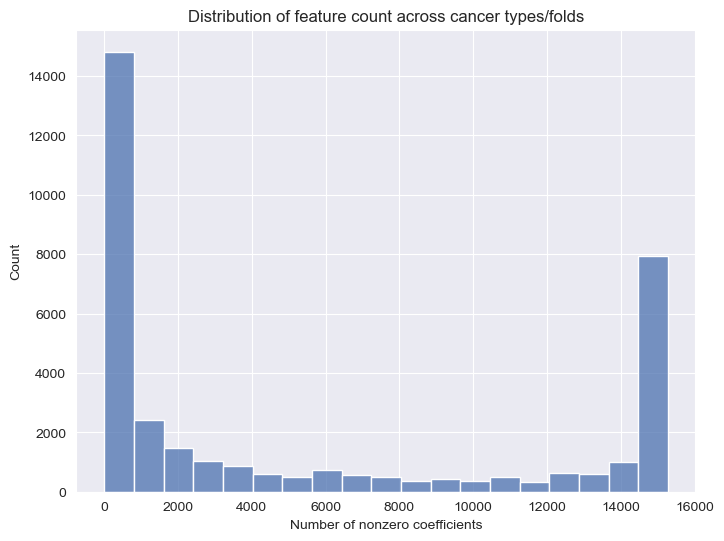

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero coefficients')

### Get "best" LASSO parameters and compare performance across all genes

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset below, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [7]:
def get_top_and_smallest_diff(gene):
    top_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.gene == gene) & 
                    (nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    holdout_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'test') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    top_smallest_diff = (
        holdout_df.loc[top_lasso_param, 'mean_aupr'] -
        holdout_df.loc[smallest_lasso_param, 'mean_aupr']
    )
    return [gene, top_lasso_param, smallest_lasso_param, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2'))

['SETD2', 100.0, 3.16, 0.01596125000000001]


In [8]:
all_top_smallest_diff_df = []

for gene in perf_df.gene.unique():
    all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'top_lasso_param',
             'smallest_lasso_param', 'top_smallest_diff']
)
all_top_smallest_diff_df['best'] = 'top'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff < 0, 'best'
] = 'smallest'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff == 0, 'best'
] = 'zero'

print(all_top_smallest_diff_df.best.value_counts())
all_top_smallest_diff_df.head()

zero        29
top         23
smallest    18
Name: best, dtype: int64


,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
0,TP53,10.0000,0.0316,-0.002115,smallest
1,KDM5C,0.1000,0.0316,-0.103119,smallest
2,RB1,0.0316,0.0316,0.000000,zero
3,CIC,1000.0000,1000.0000,0.000000,zero
4,BRAF,0.0316,0.0316,0.000000,zero


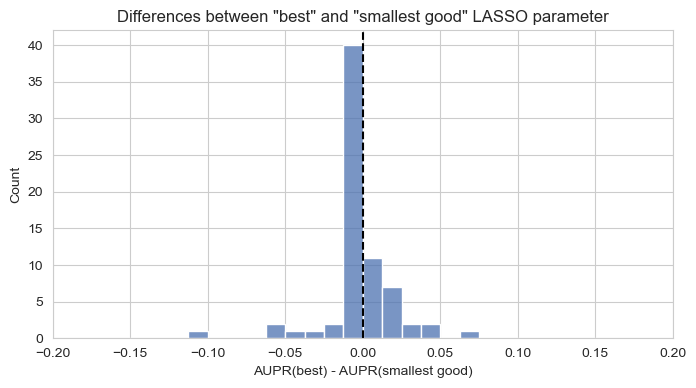

In [9]:
sns.set({'figure.figsize': (8, 4)})
sns.set_style('whitegrid')

sns.histplot(
    all_top_smallest_diff_df.top_smallest_diff,
    binwidth=0.0125, binrange=(-0.2, 0.2)
)
plt.xlim(-0.2, 0.2)
plt.title('Differences between "best" and "smallest good" LASSO parameter')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='black', linestyle='--')

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'all_{direction}_best_vs_smallest.svg'), bbox_inches='tight')

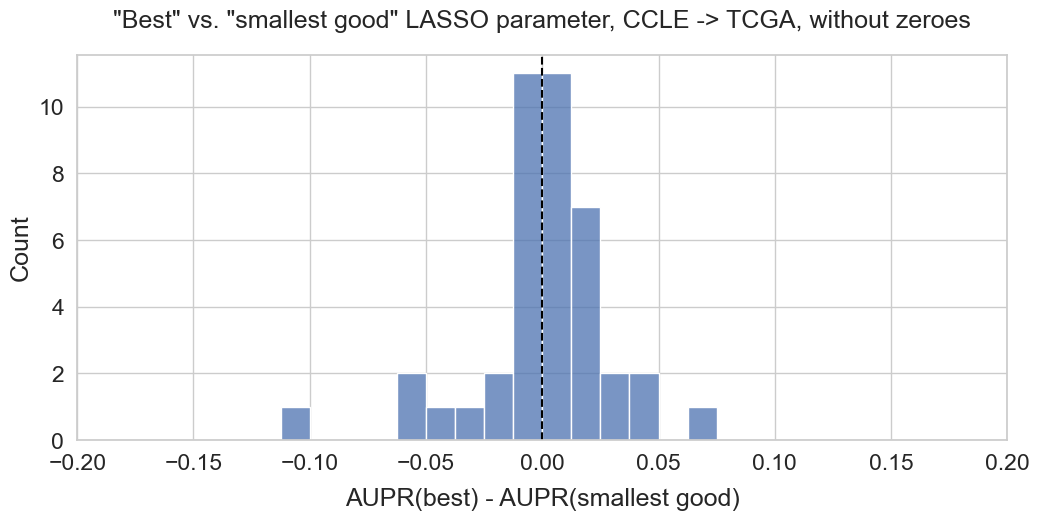

In [10]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.5):
    sns.histplot(
        all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff,
        binwidth=0.0125, binrange=(-0.2, 0.2)
    )
    plt.xlim(-0.2, 0.2)
    if direction == 'ccle_tcga':
        plt.title('"Best" vs. "smallest good" LASSO parameter, CCLE -> TCGA, without zeroes', y=1.05)
    else:
        plt.title('"Best" vs. "smallest good" LASSO parameter, TCGA -> CCLE, without zeroes', y=1.05)
    plt.xlabel('AUPR(best) - AUPR(smallest good)', labelpad=10)
    plt.gca().axvline(0, color='black', linestyle='--')

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_{direction}_best_vs_smallest_no_zeroes.svg'), bbox_inches='tight')

In [11]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
42,SMAD2,0.10,0.0316,0.067817,top
9,PBRM1,10.00,1.0000,0.046814,top
56,BAP1,3.16,0.3160,0.040529,top
21,ARID1A,10.00,0.3160,0.032184,top
65,SOX9,10.00,0.1000,0.028045,top
45,DNMT1,3.16,0.3160,0.022480,top
29,STAG2,0.10,0.0316,0.022335,top
36,IDH2,1.00,0.1000,0.021404,top
63,SETD2,100.00,3.1600,0.015961,top
38,IDH1,31.60,0.1000,0.015417,top


In [12]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
1,KDM5C,0.100,0.0316,-0.103119,smallest
11,CDKN2A,0.100,0.0316,-0.060365,smallest
30,SMAD4,0.100,0.0316,-0.055962,smallest
32,FGFR2,3.160,0.1000,-0.044965,smallest
52,KIT,1000.000,10.0000,-0.033248,smallest
13,FLT3,3.160,0.1000,-0.019652,smallest
6,ARID2,100.000,0.1000,-0.013614,smallest
64,CASP8,31.600,0.1000,-0.010511,smallest
16,SMARCA4,3.160,0.0316,-0.007573,smallest
46,ABL1,0.316,0.1000,-0.006835,smallest


### Compare TCGA and CCLE performance for each gene

Given the "best" LASSO parameter (in terms of validation performance) for each gene, we want to look at relative performance on the TCGA validation set and on the held-out CCLE data.

We expect there to be some genes where we can predict mutation status well both within TCGA and on CCLE (both "cv" and "test" performance are good), some genes where we can predict well on TCGA but we can't transfer our predictions to CCLE ("cv" performance is decent/good and "test" performance is poor), and some genes where we can't predict well on either set (both "cv" and "test" performance are poor).

In [13]:
cv_perf_df = (
    perf_df[(perf_df.data_type == 'cv') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
).copy()
cv_perf_df.lasso_param = cv_perf_df.lasso_param.astype(float)

print(cv_perf_df.shape)
cv_perf_df.head()

(11868, 7)


,auroc,aupr,gene,seed,data_type,fold,lasso_param
2,0.50000,0.70025,TP53,1,cv,0,3.160000e-03
5,0.50000,0.69018,TP53,1,cv,1,3.160000e-03
8,0.50000,0.70277,TP53,1,cv,2,3.160000e-03
11,0.50000,0.68262,TP53,1,cv,3,3.160000e-03
2,0.84702,0.92706,TP53,42,cv,0,3.160000e+06


In [14]:
test_perf_df = (
    perf_df[(perf_df.data_type == 'test') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
).copy()
test_perf_df.lasso_param = test_perf_df.lasso_param.astype(float)

print(test_perf_df.shape)
test_perf_df.head()

(11868, 7)


,auroc,aupr,gene,seed,data_type,fold,lasso_param
1,0.50000,0.47619,TP53,1,test,0,3.160000e-03
4,0.50000,0.47619,TP53,1,test,1,3.160000e-03
7,0.50000,0.47619,TP53,1,test,2,3.160000e-03
10,0.50000,0.47619,TP53,1,test,3,3.160000e-03
1,0.76699,0.74183,TP53,42,test,0,3.160000e+06


In [15]:
# get performance using "best" lasso parameter, across all seeds and folds
# (so we can plot the distribution/visualize the variance across CV splits)
best_perf_df = (
    all_top_smallest_diff_df.loc[:, ['gene', 'top_lasso_param']]
      .merge(cv_perf_df,
             left_on=['gene', 'top_lasso_param'],
             right_on=['gene', 'lasso_param'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'cv_auroc',
                       'aupr': 'cv_aupr'})
      .merge(test_perf_df,
             left_on=['gene', 'top_lasso_param', 'seed', 'fold'],
             right_on=['gene', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'test_auroc',
                       'aupr': 'test_aupr'})
)
best_perf_df['cv_test_auroc_diff'] = (
    best_perf_df.cv_auroc - best_perf_df.test_auroc
)
best_perf_df['cv_test_aupr_diff'] = (
    best_perf_df.cv_aupr - best_perf_df.test_aupr
)

print(best_perf_df.shape)
best_perf_df.sort_values(by='cv_test_aupr_diff', ascending=False).head()

(544, 12)


,gene,top_lasso_param,cv_auroc,cv_aupr,seed,data_type_x,fold,test_auroc,test_aupr,data_type_y,cv_test_auroc_diff,cv_test_aupr_diff
377,NOTCH2,10.0,1.00000,1.00000,42,cv,1,0.46538,0.057050,test,0.53462,0.942950
44,JAK1,0.1,1.00000,1.00000,42,cv,0,0.35930,0.067517,test,0.64070,0.932483
460,RNF43,10.0,1.00000,1.00000,1,cv,0,0.36619,0.071155,test,0.63381,0.928845
342,CTNNB1,10.0,1.00000,1.00000,1,cv,2,0.51727,0.232240,test,0.48273,0.767760
41,JAK1,0.1,0.96667,0.83333,1,cv,1,0.41969,0.076806,test,0.54698,0.756524


In [16]:
plot_df = (best_perf_df
    .drop(columns=['cv_test_auroc_diff', 'cv_test_aupr_diff', 'cv_auroc', 'test_auroc'])
    .melt(id_vars=['gene', 'top_lasso_param', 'seed', 'fold'],
          value_vars=['cv_aupr', 'test_aupr'],
          var_name=['dataset_metric'])
)
plot_df.head()

,gene,top_lasso_param,seed,fold,dataset_metric,value
0,TP53,10.0,1,0,cv_aupr,0.92055
1,TP53,10.0,1,1,cv_aupr,0.93996
2,TP53,10.0,1,2,cv_aupr,0.95128
3,TP53,10.0,1,3,cv_aupr,0.93992
4,TP53,10.0,42,0,cv_aupr,0.94644


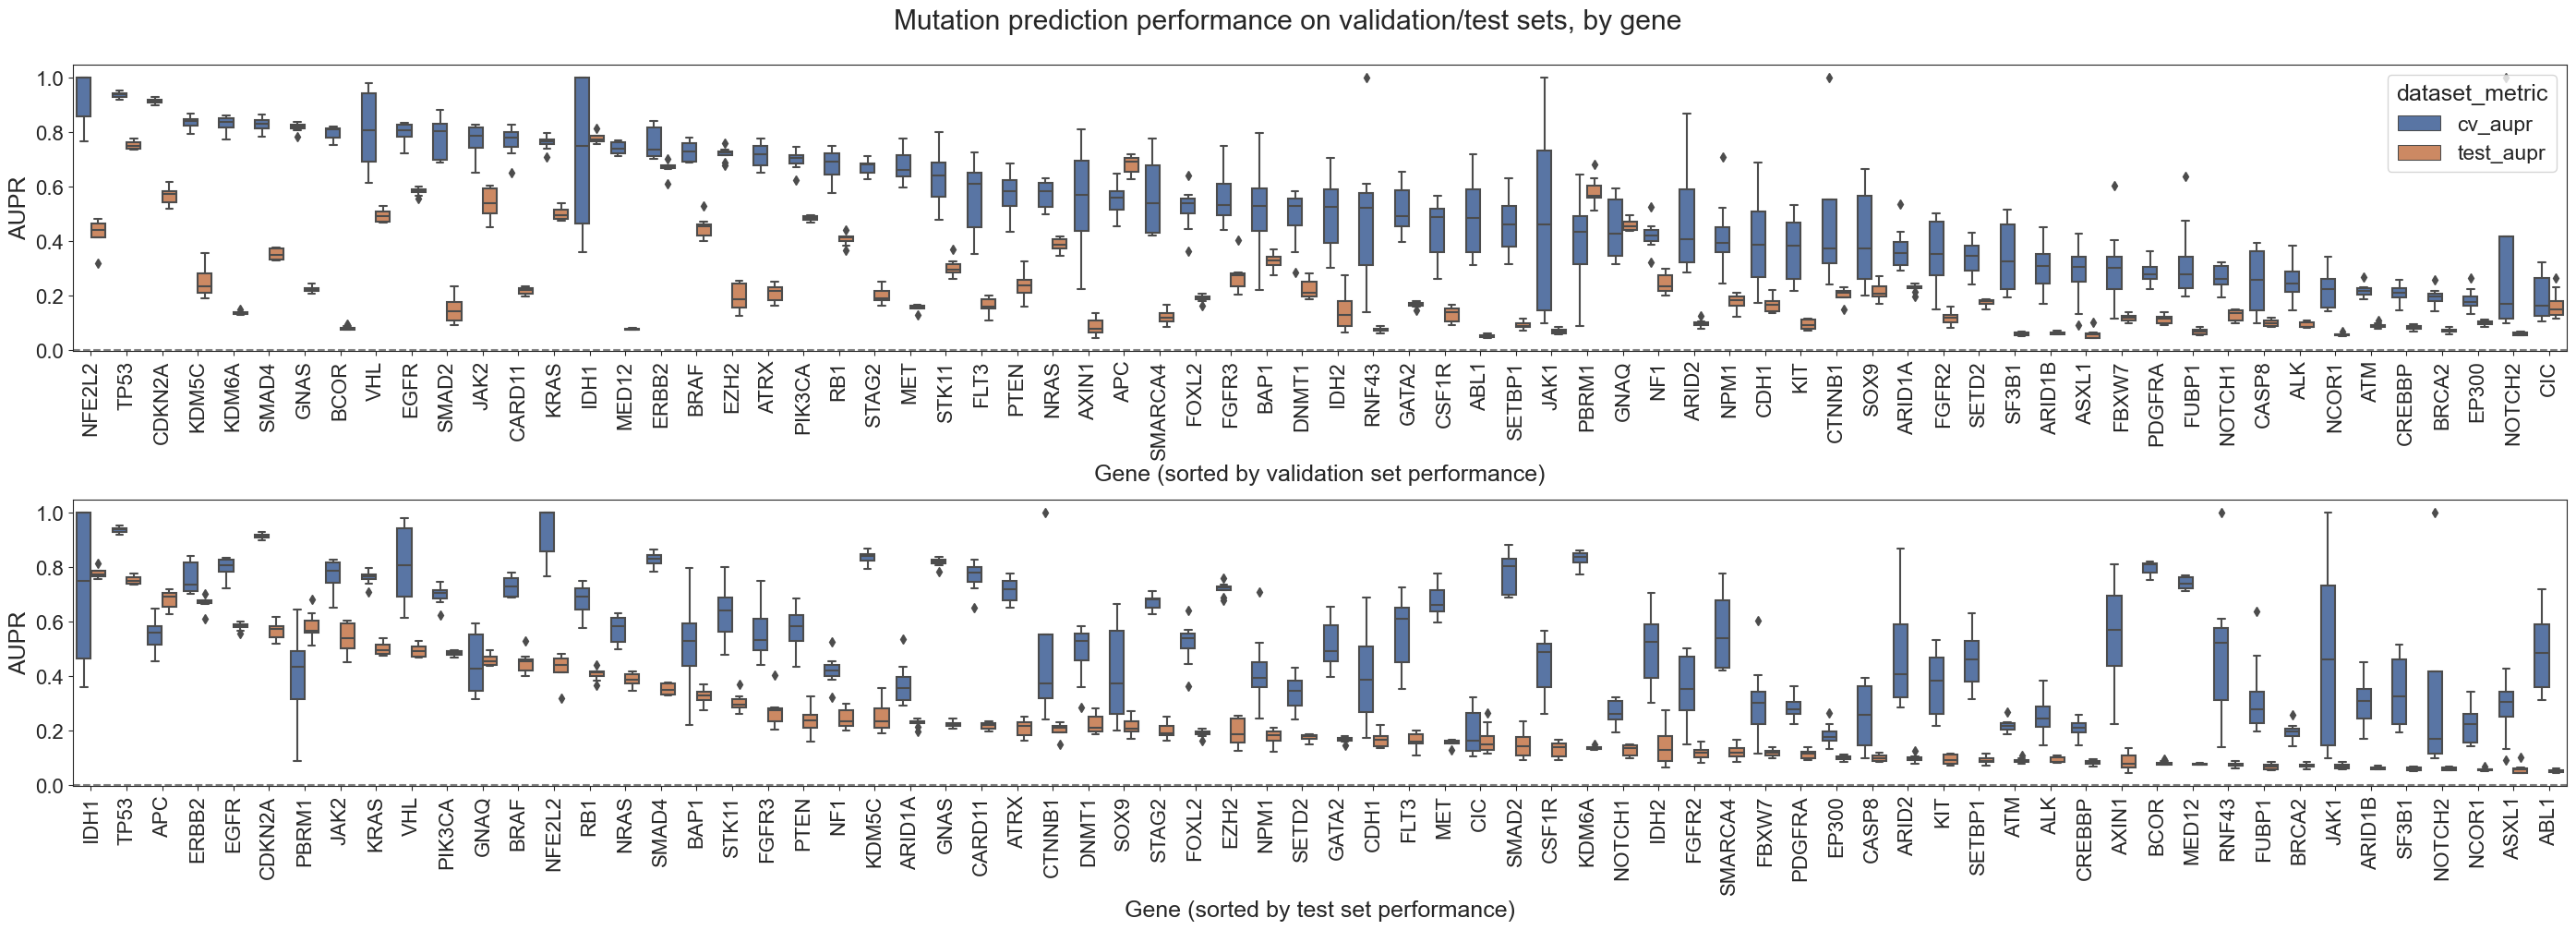

In [17]:
# plot cv/test performance distribution for each gene
sns.set({'figure.figsize': (28, 10)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

# order boxes by cv performance per gene
cv_gene_order = (plot_df[plot_df.dataset_metric == 'cv_aupr']
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='value', ascending=False)
).index.get_level_values(0).values

# order boxes by test performance per gene
test_gene_order = (plot_df[plot_df.dataset_metric == 'test_aupr']
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='value', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.5):
    sns.boxplot(data=plot_df, order=cv_gene_order,
                x='gene', y='value', hue='dataset_metric', ax=axarr[0])
    axarr[0].axhline(0.0, linestyle='--', color='grey')
    axarr[0].tick_params(axis='x', rotation=90, labelsize=16)
    axarr[0].tick_params(axis='y', labelsize=16)
    axarr[0].set_xlabel('Gene (sorted by validation set performance)', size=18)
    axarr[0].set_ylabel('AUPR', size=18)
    
    sns.boxplot(data=plot_df, order=test_gene_order,
                x='gene', y='value', hue='dataset_metric', ax=axarr[1])
    axarr[1].legend([], [], frameon=False)
    axarr[1].axhline(0.0, linestyle='--', color='grey')
    axarr[1].tick_params(axis='x', rotation=90, labelsize=16)
    axarr[1].tick_params(axis='y', labelsize=16)
    axarr[1].set_xlabel('Gene (sorted by test set performance)', size=18)
    axarr[1].set_ylabel('AUPR', size=18)
    
    plt.suptitle(f'Mutation prediction performance on validation/test sets, by gene', y=1.0025)
    
plt.tight_layout()

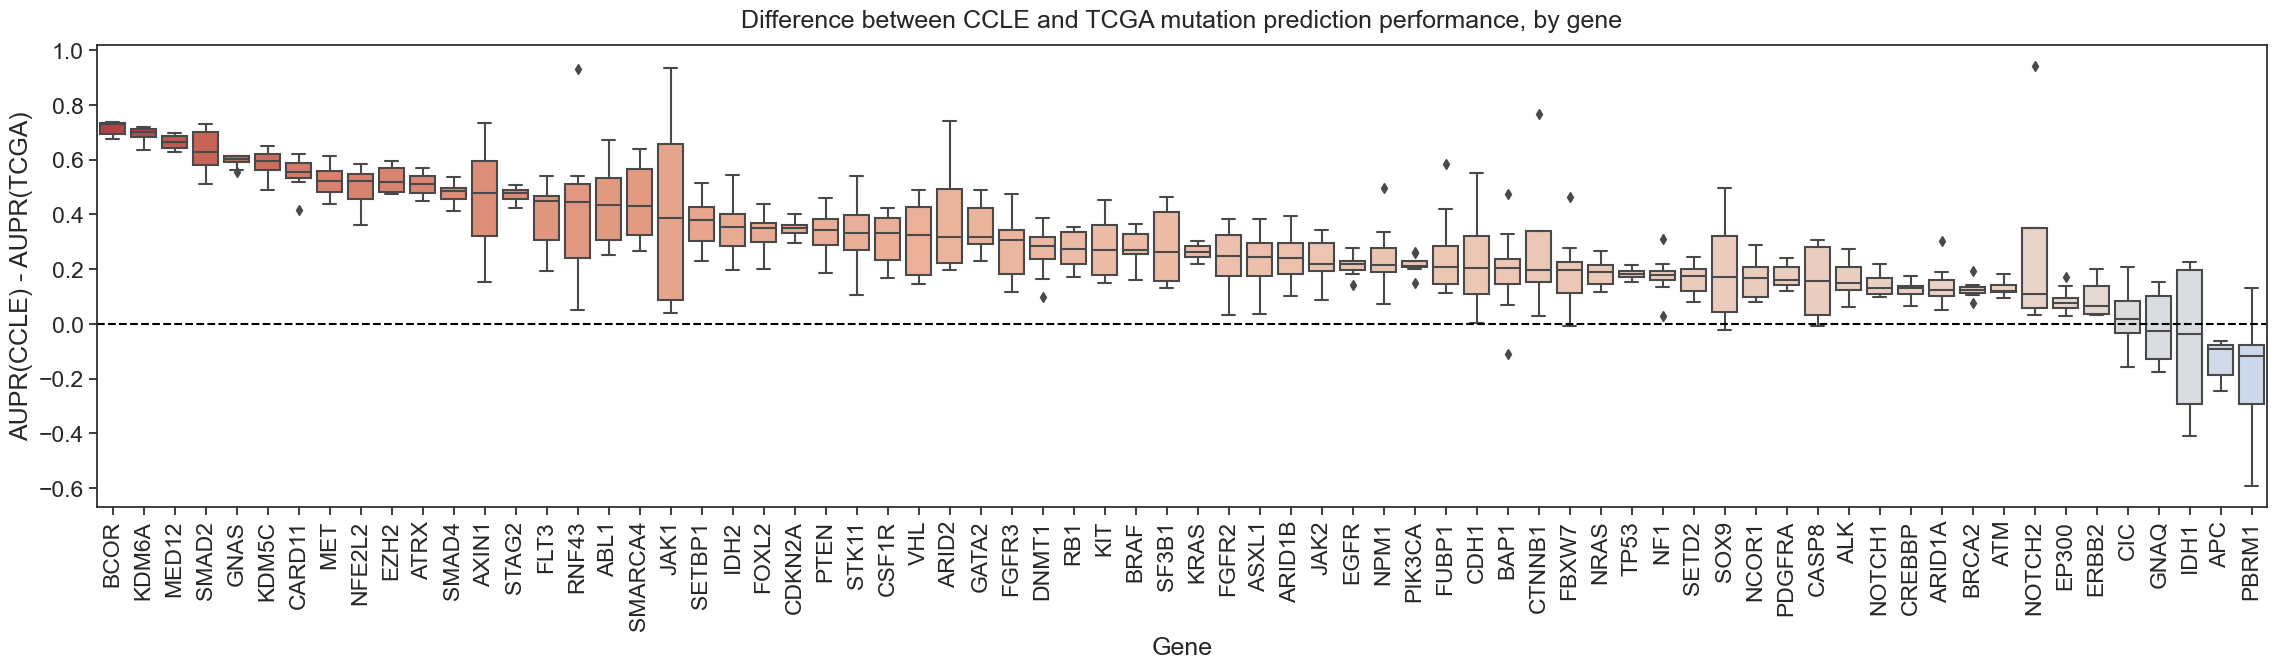

In [18]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median (cv - test) diff per gene
# order boxes by median (cv - test) diff per gene
medians = (best_perf_df
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
)['cv_test_aupr_diff'].values

gene_order = (best_perf_df
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.5):
    # map median performance values to colors on scale centered at 0
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    norm = Normalize(vmin=-0.8, vmax=0.8)
    ax = sns.boxplot(data=best_perf_df, order=gene_order,
                     x='gene', y='cv_test_aupr_diff',
                     palette=[cmap(norm(m)) for m in medians])
    ax.axhline(0.0, linestyle='--', color='black')
    plt.xticks(rotation=90)
    plt.xlabel('Gene')
    
    if direction == 'ccle_tcga':
        plt.title(f'Difference between CCLE and TCGA mutation prediction performance, by gene', y=1.02)
        plt.ylabel('AUPR(CCLE) - AUPR(TCGA)')
    else:
        plt.title(f'Difference between TCGA and CCLE mutation prediction performance, by gene', y=1.02)
        plt.ylabel('AUPR(TCGA) - AUPR(CCLE)')
        
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_{direction}_gene_boxes.svg'), bbox_inches='tight')